# Grouping municipalities and merging attractors

In this script we group the municipalitites based their distance to the attractor municipalities and merge the existing groups based on any overlapping attractor municipalities that belong in multiple groups.

In the first stage (before developing a time radius), we find a cartesian radius proportional to the area of each attractor municipality. We then find the municipalities that fall within a circle with such radius and center on the centroid of the attractor municipality. The output of this is a binary csv file with 1 signifying part of the region with the attractor municipality in the column heading and 0 otherwise.

Secondly, we identify which attractor municipalities fall within the regionalization radius of other attractor municipalities. We update the output csv from before to have 2 signify an attractor municipality being within the regionalization radius of another attractor, 1 signify a non-attractor municipality being within region, and 0 otherwise. 

In [1]:
# Libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial

import json
from shapely.geometry import Point, mapping
from shapely.ops import transform

import random

# Paths and names

In [2]:
# Define path of municipalities shape file

# this is allison's path
# entities_path = 'marco_geoestadistico_2018/'

# this is jerry's path
entities_path = '../marco_geoestadistico_2018/'


In [3]:
# Define a dictionary to read the shape files

entities= {
    '01' :['01Ags','01_aguascalientes'],
    '02' :['02BC','02_bajacalifornia'],
    '03' :['03BCS','03_bajacaliforniasur'],
    '04' :['04Camp', '04_campeche'],
    '05' :['05Coah','05_coahuiladezaragoza'],
    '06' :['06Col','06_colima'],
    '07' :[ '07Chs','07_chiapas'],
    '08' :['08Chih','08_chihuahua'],
    '09' :['09CdMx','09_ciudaddemexico'],
    '10' :['10Dur','10_durango'],
    '11' :['11Gto', '11_guanajuato'],
    '12' :['12Gro','12_guerrero'],
    '13' :['13Hgo','13_hidalgo'],
    '14' :['14Jal','14_jalisco'],
    '15' :['15EdoMex','15_mexico'],
    '16' :['16Mich','16_michoacandeocampo'],
    '17' :['17Mor','17_morelos'],
    '18' :['18Nay','18_nayarit'],
    '19' :['19NL', '19_nuevoleon'],
    '20' :['20Oax', '20_oaxaca'],
    '21' :['21Pue', '21_puebla'],
    '22' :['22Qro','22_queretaro'],
    '23' :['23QRoo','23_quintanaroo'], 
    '24' :['24SLP','24_sanluispotosi'],
    '25' :['25Sin','25_sinaloa'],
    '26' :['26Son','26_sonora'],
    '27' :['27Tab','27_tabasco'],
    '28' :['28Tamps','28_tamaulipas'],
    '29' :['29Tlax','29_tlaxcala'],
    '30' :['30Ver','30_veracruzignaciodelallave'],
    '31' :[ '31Yuc','31_yucatan'],
    '32' :[ '32Zac','32_zacatecas']   
}

# Municipality shapefiles

In [4]:
# Read in municipality shapefiles 

urban_shapes = []

for i in range(1,33):
    a = str(i).zfill(2)
    
    urban_agebs = gpd.read_file(entities_path + entities[a][1]+'/conjunto de datos/'+entities[a][1][0:2]+'mun'+'.shp')
    
    urban_shapes.append(urban_agebs)
    
urban_shapes = pd.concat(urban_shapes)

# Area and centroid calculations

In [5]:
# Find area of all municipalities

# Ensure projection consistency
urban_shapes = urban_shapes.to_crs({'init' :'epsg:4326'})

gs = gpd.GeoSeries(urban_shapes['geometry'])

areas = []
for i in gs:  
    area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=i.bounds[1],
                lat_2=i.bounds[3])),
        i)
    areas.append(area.area/1000000)
    
urban_shapes['area'] = areas

In [6]:
# Find centroid of all municipalities

centroid = gs.centroid
urban_shapes['centroid'] = centroid

# Radius calculations for attractor municipalities

In [7]:
# Read in attractor municipalities

attractors = pd.read_csv('complejidad_alta.csv')

# Standardize ID number
for i in range(0,137):
    attractors['cve_mun'].iloc[i] = str(attractors['cve_mun'].iloc[i]).zfill(5)

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# Find radius for each municipality

att_shapes = urban_shapes.loc[urban_shapes['CVEGEO'].isin(attractors['cve_mun'])]

min_area = att_shapes['area'].min()

radius = []
for i in range(0,137):
    area = att_shapes['area'].iloc[i]
    radius.append(50*(math.log(area/min_area,10) + 1))
    
att_shapes['radius'] = radius

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


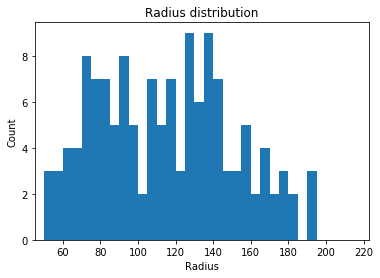

In [9]:
# Show radius distribution

bins = np.arange(0, 200, 5) # fixed bin size

plt.xlim([min(radius)-5, max(radius)+5])

plt.hist(radius, bins=bins)
plt.title('Radius distribution')
plt.xlabel('Radius')
plt.ylabel('Count')

plt.show()

# Regionalization using radius

In [10]:
# Create a circle with center at the centroid of each attractor municipality and corresponding radius

import math

polygon_list = []
    
def find_circle(point, radius_individual):

    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )
    
    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(radius_individual*1000)

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)

    return (Polygon(buffer_wgs84))

for i in range(att_shapes.shape[0]):
    
    polygon_list.append(find_circle(att_shapes['centroid'].iloc[i],att_shapes['radius'].iloc[i]))

att_shapes['circlerange'] = polygon_list

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# Output csv

phase_1 = urban_shapes

for t in range(att_shapes.shape[0]):
    one_column = []
    
    check_polygon = att_shapes['circlerange'].iloc[t]
    
    for i in range(urban_shapes.shape[0]):
        
        check_point = (urban_shapes['centroid'].iloc[i])
        
        if urban_shapes['CVEGEO'].iloc[i] in attractors['cve_mun'].unique():
            dummy_value = 2 * (check_polygon.contains(check_point))
        else:
            dummy_value = 1 * (check_polygon.contains(check_point))
        
        one_column.append(dummy_value)
    
    temp_str = att_shapes['CVEGEO'].iloc[t]
    
    phase_1[temp_str] = one_column
    
phase_1 = phase_1.drop(['geometry', 'centroid'], axis=1)

export_csv = phase_1.to_csv('phase_1.csv')

# Distribution of overlaps

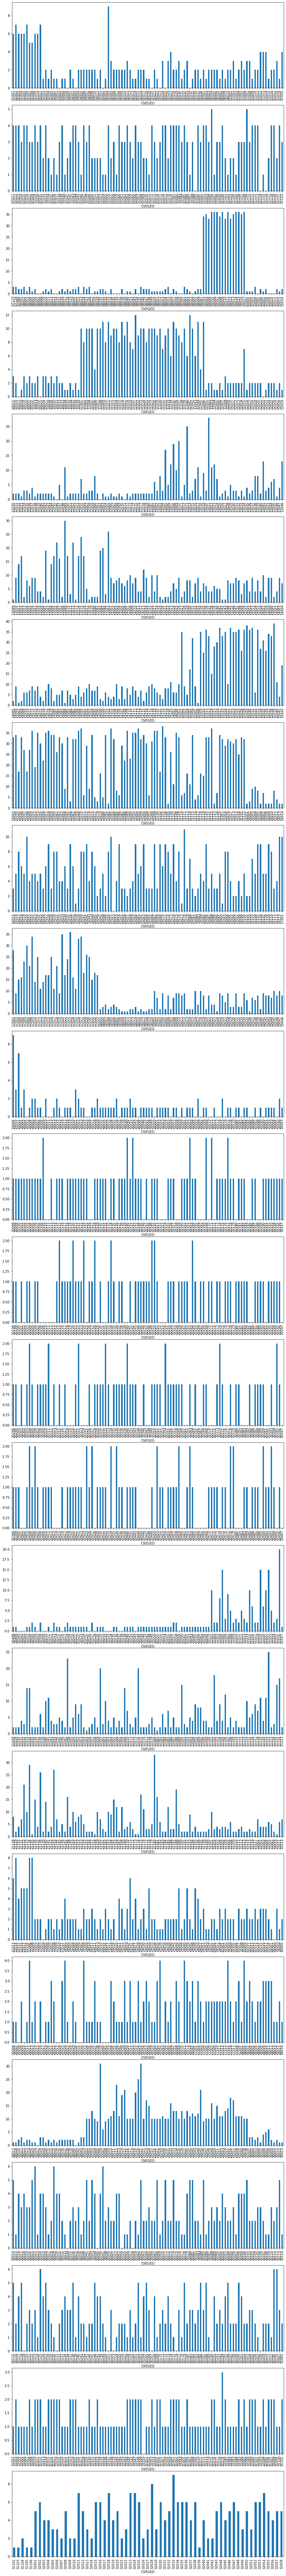

In [13]:
# Plot number overlaps for all municipalities

overlap = phase_1.drop(['CVE_ENT', 'CVE_MUN', 'NOMGEO', 'area'], axis=1)

overlap.set_index('CVEGEO', inplace=True)

overlap_t = overlap.T

overlap_count = overlap_t.astype(bool).sum()

for i in attractors['cve_mun']:
    overlap_count[i] = overlap_count[i] - 1
    
fig, axes = plt.subplots(nrows=25)

for i in range(25):
    overlap_count_sample = overlap_count.iloc[i*100:i*100+100]
    overlap_count_sample.plot.bar(ax=axes[i], figsize=(15,145), rot=90);

In [14]:
# Summary of all overlaps

overlap_count.describe()

count    2463.000000
mean        4.919204
std         7.394339
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        39.000000
dtype: float64

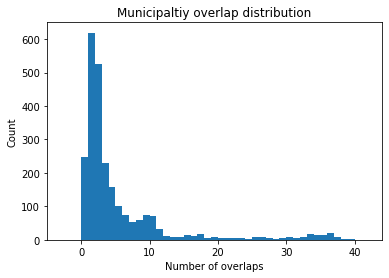

In [15]:
# Distribution histogram of all overlaps

bins = np.arange(0, 50, 1) # fixed bin size

plt.xlim([min(overlap_count)-5, max(overlap_count)+5])

plt.hist(overlap_count, bins=bins)
plt.title('Municipaltiy overlap distribution')
plt.xlabel('Number of overlaps')
plt.ylabel('Count')

plt.show()

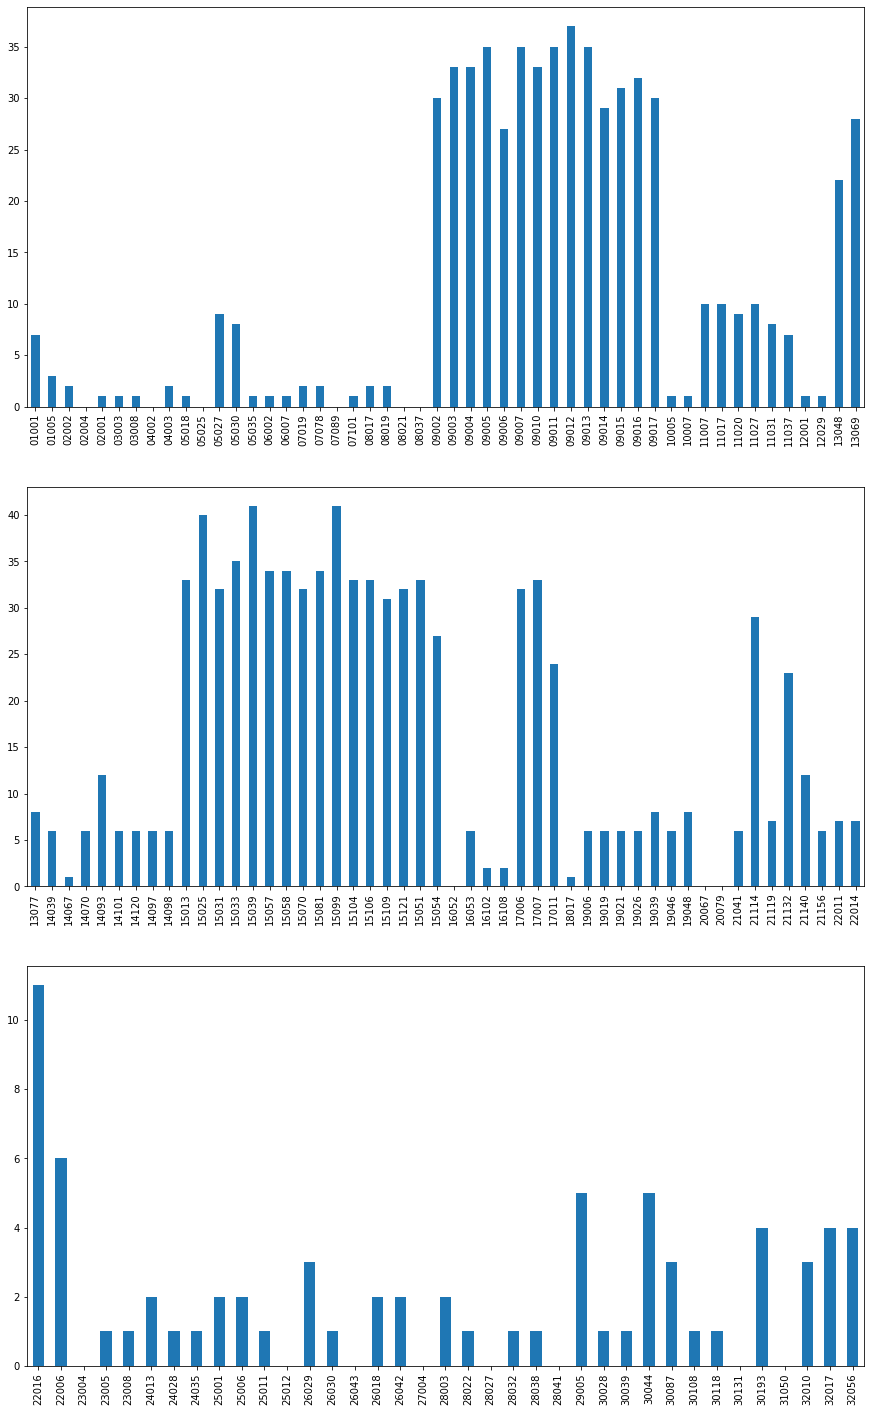

In [16]:
# Plot number overlaps for attractor municipalities

att_only = phase_1.loc[phase_1['CVEGEO'].isin(attractors['cve_mun'])]

att_only = att_only.drop(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'NOMGEO', 'area'], axis=1)

att_overlap_count = att_only.astype(bool).sum()

att_overlap_count = att_overlap_count - 1
    
fig, axes = plt.subplots(nrows=3)

for i in range(3):
    att_overlap_count_sample = att_overlap_count.iloc[i*50:i*50+50]
    att_overlap_count_sample.plot.bar(ax=axes[i], figsize=(15,25), rot=90);

In [17]:
# Summary of attractor overlaps

att_overlap_count.describe()

count    137.000000
mean      11.153285
std       13.323404
min        0.000000
25%        1.000000
50%        6.000000
75%       24.000000
max       41.000000
dtype: float64

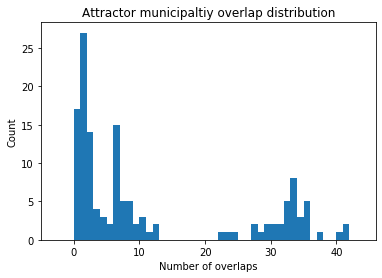

In [18]:
# Distribution histogram of attractor overlaps

bins = np.arange(0, 60, 1) # fixed bin size

plt.xlim([min(att_overlap_count)-5, max(att_overlap_count)+5])

plt.hist(att_overlap_count, bins=bins)
plt.title('Attractor municipaltiy overlap distribution')
plt.xlabel('Number of overlaps')
plt.ylabel('Count')

plt.show()

# Merging regions

In [19]:
# Naively merge all attractor regions that overlap with other attractors

Reg_dict = {}

for att in overlap.columns:
    Reg_dict[att] = 0

i = 0

merged = pd.DataFrame(index = overlap.index)
for col in overlap.columns:
    l = overlap.index[overlap[col] == 2].tolist()
    regions = []
    for att in l:
        if Reg_dict[att] != 0:
            regions.append(Reg_dict[att])
    if regions == []:
        i += 1
        for att in l:
            Reg_dict[att] = i
            merged[i] = overlap[att]
    else:
        region = min(set(regions))
        for att in l:
            Reg_dict[att] = region
            merged[region] = merged[region] + overlap[att]

In [20]:
# Create dictionary documenting naive regionalization

Reg_dict_naive = {}

for col in merged.columns:
    Reg_dict_naive[col] = merged.index[merged[col] > 0].tolist()

In [21]:
# Set municipality ID to be the index

urban_shapes.set_index("CVEGEO", inplace = True)

No handles with labels found to put in legend.


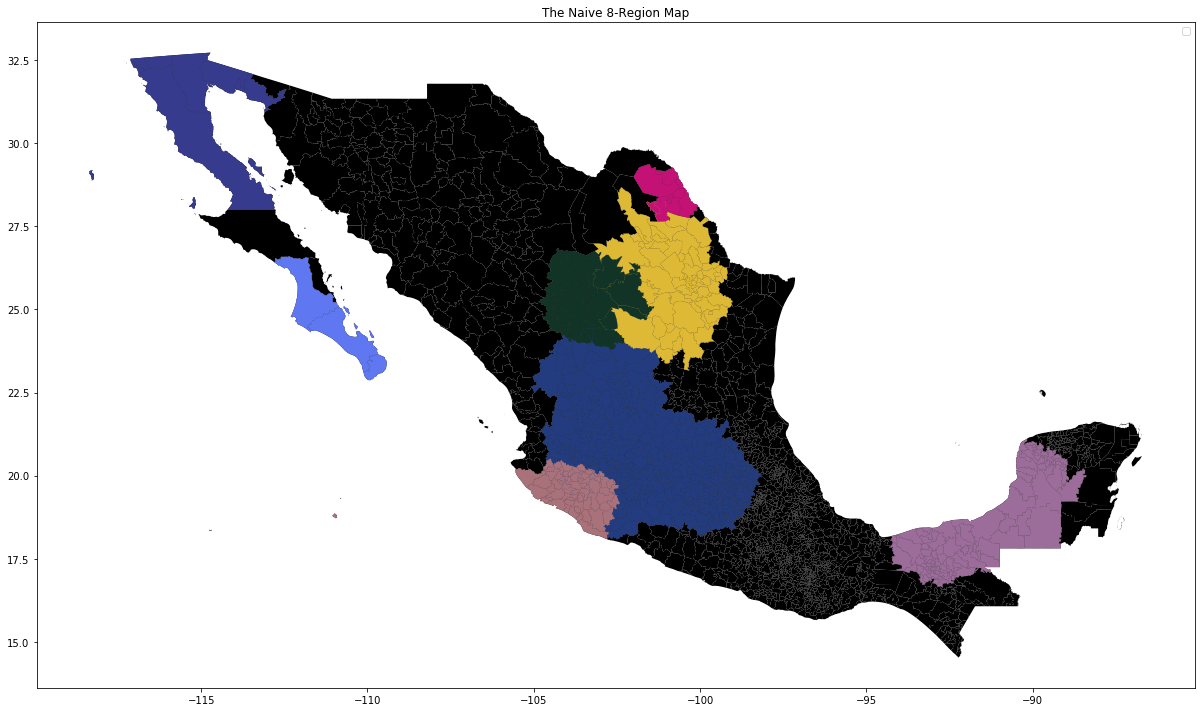

In [22]:
# Plot Phase 1 naive regionalization

fig, ax = plt.subplots(figsize=(20,10))

(urban_shapes).plot(ax=ax, color='black');

def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return ("#"+color)

for i in range (1,9):
    
    loc_num = Reg_dict_naive[i]
    
    (urban_shapes.loc[loc_num,:]).plot(ax=ax, color=randomcolor())
    
plt.legend()

plt.title('The Naive 8-Region Map')

plt.tight_layout();

In [23]:
# Merge attractor regions that overlap with other attractors by complexity, 1 merge per attractor

Reg_dict = {}
Merge_dict = {}

for att in overlap.columns:
    Reg_dict[att] = 0
    
for att in overlap.columns:
    Merge_dict[att] = 0

i = 0

merged = pd.DataFrame(index = overlap.index)

for col in attractors['cve_mun']:
    if Merge_dict[col] == 0:
        i += 1
        l = overlap.index[overlap[col] == 2].tolist()
        merged[i] = overlap[col]
        for att in l:
            Merge_dict[att] = 1
            merged[i] = merged[i] + overlap[att]

In [24]:
# Create dictionary documenting 1-pass regionalization

Reg_dict1 = {}

for col in merged.columns:
    Reg_dict1[col] = merged.index[merged[col] > 0].tolist()

No handles with labels found to put in legend.


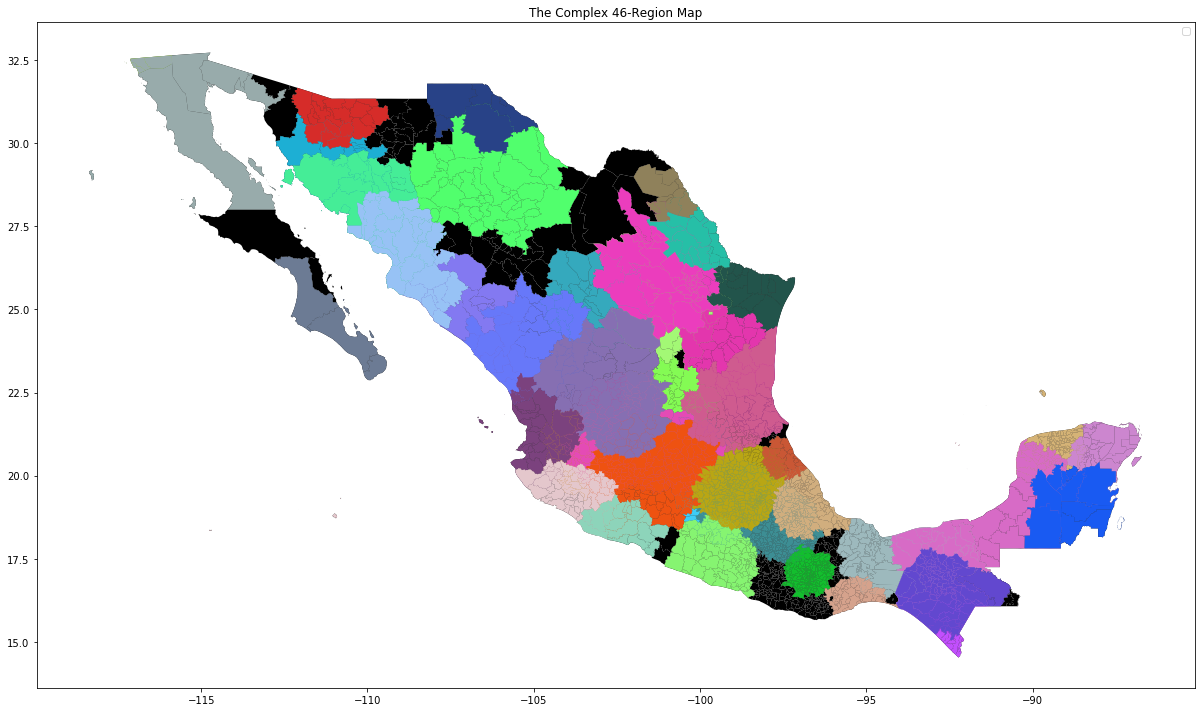

In [42]:
# Plot Phase 1 1-pass regionalization, before assigning overlapping non-attractor municipalities

fig, ax = plt.subplots(figsize=(20,10))

(urban_shapes).plot(ax=ax, color='black');

for i in range (1,47):
    
    loc_num = Reg_dict1[i]
    
    (urban_shapes.loc[loc_num,:]).plot(ax=ax, color=randomcolor())
    
plt.legend()

plt.title('The Complex 46-Region Map')

plt.tight_layout();

In [48]:
Reg_dict

{'01001': 0,
 '01005': 0,
 '02002': 0,
 '02004': 0,
 '02001': 0,
 '03003': 0,
 '03008': 0,
 '04002': 0,
 '04003': 0,
 '05018': 0,
 '05025': 0,
 '05027': 0,
 '05030': 0,
 '05035': 0,
 '06002': 0,
 '06007': 0,
 '07019': 0,
 '07078': 0,
 '07089': 0,
 '07101': 0,
 '08017': 0,
 '08019': 0,
 '08021': 0,
 '08037': 0,
 '09002': 0,
 '09003': 0,
 '09004': 0,
 '09005': 0,
 '09006': 0,
 '09007': 0,
 '09010': 0,
 '09011': 0,
 '09012': 0,
 '09013': 0,
 '09014': 0,
 '09015': 0,
 '09016': 0,
 '09017': 0,
 '10005': 0,
 '10007': 0,
 '11007': 0,
 '11017': 0,
 '11020': 0,
 '11027': 0,
 '11031': 0,
 '11037': 0,
 '12001': 0,
 '12029': 0,
 '13048': 0,
 '13069': 0,
 '13077': 0,
 '14039': 0,
 '14067': 0,
 '14070': 0,
 '14093': 0,
 '14101': 0,
 '14120': 0,
 '14097': 0,
 '14098': 0,
 '15013': 0,
 '15025': 0,
 '15031': 0,
 '15033': 0,
 '15039': 0,
 '15057': 0,
 '15058': 0,
 '15070': 0,
 '15081': 0,
 '15099': 0,
 '15104': 0,
 '15106': 0,
 '15109': 0,
 '15121': 0,
 '15051': 0,
 '15054': 0,
 '16052': 0,
 '16053': 0,

In [29]:
Reg_dict1[1]

['01001',
 '01003',
 '01005',
 '11001',
 '11008',
 '11012',
 '11016',
 '11020',
 '11023',
 '11025',
 '11026',
 '11031',
 '11037',
 '14001',
 '14002',
 '14003',
 '14004',
 '14005',
 '14006',
 '14007',
 '14008',
 '14009',
 '14010',
 '14011',
 '14012',
 '14013',
 '14014',
 '14016',
 '14017',
 '14018',
 '14019',
 '14023',
 '14024',
 '14026',
 '14028',
 '14029',
 '14030',
 '14031',
 '14032',
 '14033',
 '14034',
 '14035',
 '14036',
 '14037',
 '14038',
 '14039',
 '14040',
 '14044',
 '14045',
 '14046',
 '14047',
 '14048',
 '14050',
 '14051',
 '14052',
 '14053',
 '14054',
 '14055',
 '14056',
 '14057',
 '14059',
 '14060',
 '14062',
 '14063',
 '14066',
 '14069',
 '14070',
 '14071',
 '14072',
 '14073',
 '14074',
 '14075',
 '14076',
 '14077',
 '14078',
 '14079',
 '14082',
 '14083',
 '14085',
 '14086',
 '14088',
 '14089',
 '14090',
 '14091',
 '14092',
 '14093',
 '14094',
 '14095',
 '14096',
 '14099',
 '14101',
 '14102',
 '14103',
 '14104',
 '14105',
 '14106',
 '14107',
 '14108',
 '14109',
 '14110',


In [33]:
compelx_rega = pd.DataFrame.from_dict(Reg_dict1)

compelx_reg

ValueError: arrays must all be same length

In [39]:

data_dic = []

for i in range (1,47):
    
    data_dic.append(Reg_dict1[i])
    
compelx_reg = pd.DataFrame(data = data_dic)    

compelx_reg.to_csv('Complex_ID.csv')

In [43]:
urban_shapes

CVE_ENT CVE_MUN                  NOMGEO  \
CVEGEO                                           
01001       01     001          Aguascalientes   
01002       01     002                Asientos   
01003       01     003                Calvillo   
01004       01     004                  CosÃ­o   
01005       01     005           JesÃºs MarÃ­a   
...        ...     ...                     ...   
32054       32     054           Villa Hidalgo   
32055       32     055              Villanueva   
32056       32     056               Zacatecas   
32057       32     057                Trancoso   
32058       32     058  Santa MarÃ­a de la Paz   

                                                 geometry         area  \
CVEGEO                                                                   
01001   POLYGON ((-102.10641 22.06035, -102.10368 22.0...  1178.100251   
01002   POLYGON ((-102.05189 22.29144, -102.05121 22.2...   549.008958   
01003   POLYGON ((-102.68569 22.09963, -102.69087 22.0...   932.737577   
01004   POLYGON ((-102.28787 22.41649, -102.28753 22.4...   129.738928   
01005   POLYGON ((-102.33568 22.05067, -102.33348 22.0...   504.989583   
...                                                   ...          ...   
32054   POLYGON ((-101.69490 22.51777, -101.69472 22.5...   375.359314   
32055   POLYGON ((-102.78252 22.67373, -102.78221 22.6...  2179.158389   
32056   POLYGON ((-102.53955 22.77820, -102.53954 22.7...   441.496537   
32057   POLYGON ((-102.22547 22.80920, -102.22946 22.7...   220.805234   
32058   POLYGON ((-103.38994 21.57379, -103.38332 21.5...   278.351363   

                           centroid  01001  01005  02002  02004  ...  30044  \
CVEGEO                                                           ...          
01001   POINT (-102.29580 21.81144)      2      2      0      0  ...      0   
01002   POINT (-102.04564 22.12651)      1      1      0      0  ...      0   
01003   POINT (-102.70490 21.90069)      1      1      0      0  ...      0   
01004   POINT (-102.29704 22.36063)      1      1      0      0  ...      0   
01005   POINT (-102.44565 21.93212)      2      2      0      0  ...      0   
...                             ...    ...    ...    ...    ...  ...    ...   
32054   POINT (-101.71432 22.40736)      1      1      0      0  ...      0   
32055   POINT (-102.85151 22.29827)      1      1      0      0  ...      0   
32056   POINT (-102.67808 22.73573)      2      2      0      0  ...      0   
32057   POINT (-102.31200 22.75563)      1      1      0      0  ...      0   
32058   POINT (-103.34390 21.52254)      1      1      0      0  ...      0   

        30087  30108  30118  30131  30193  31050  32010  32017  32056  
CVEGEO                                                                 
01001       0      0      0      0      0      0      0      2      2  
01002       0      0      0      0      0      0      1      1      1  
01003       0      0      0      0      0      0      1      1      1  
01004       0      0      0      0      0      0      1      1      1  
01005       0      0      0      0      0      0      2      2      2  
...       ...    ...    ...    ...    ...    ...    ...    ...    ...  
32054       0      0      0      0      0      0      1      1      1  
32055       0      0      0      0      0      0      1      1      1  
32056       0      0      0      0      0      0      2      2      2  
32057       0      0      0      0      0      0      1      1      1  
32058       0      0      0      0      0      0      0      0      0  

[2463 rows x 143 columns]

In [44]:
compelx_reg

0      1      2      3      4      5      6      7      8      9    ...  \
0   01001  01003  01005  11001  11008  11012  11016  11020  11023  11025  ...   
1   09002  09003  09004  09005  09006  09007  09008  09009  09010  09011  ...   
2   05001  05004  05005  05006  05007  05008  05010  05011  05016  05018  ...   
3   01002  01004  01006  01009  01010  01011  11013  11014  11022  11029  ...   
4   04001  04005  04008  31001  31002  31003  31004  31005  31006  31007  ...   
5   11001  11002  11003  11004  11005  11006  11007  11008  11009  11010  ...   
6   01001  01002  01003  01004  01005  01006  01007  01008  01009  01010  ...   
7   09002  09003  09004  09005  09006  09007  09008  09009  09010  09011  ...   
8   02003  02004  02005   None   None   None   None   None   None   None  ...   
9   26001  26005  26009  26012  26013  26014  26016  26020  26021  26022  ...   
10  05009  05017  05024  05033  05035  05036  10004  10006  10007  10008  ...   
11  08001  08002  08003  08004  08006  08009  08010  08011  08012  08015  ...   
12  07002  07004  07005  07007  07008  07009  07012  07013  07014  07017  ...   
13  11001  11002  11003  11004  11005  11007  11008  11009  11010  11011  ...   
14  08001  08005  08028  08037  08050  08053   None   None   None   None  ...   
15  02002  02003  02004  02005  02001  26048  26055   None   None   None  ...   
16  04007  07005  07012  07013  07014  07016  07018  07021  07022  07023  ...   
17  20002  20021  20029  20041  20109  20142  20163  20169  20171  20228  ...   
18  08029  08046  10002  10019  10023  10026  10032  10034  10035  10037  ...   
19  19002  19003  19011  19013  19015  19016  19020  19022  19023  19027  ...   
20  08020  08030  08047  08065  08066  25001  25007  25010  26003  26005  ...   
21  10001  10003  10004  10005  10008  10014  10015  10016  10018  10019  ...   
22  07012  07017  07021  07025  07033  07043  07048  07060  07061  07062  ...   
23  14003  14006  14007  14011  14012  14017  14019  14020  14028  14031  ...   
24  23001  23002  23003  23005  23007  23008  23009  23011  31008  31012  ...   
25  04001  04002  04003  04004  04005  04006  04007  04008  04009  04010  ...   
26  08020  08030  08046  08047  08065  08066  25001  25002  25003  25007  ...   
27  12001  12002  12003  12004  12005  12006  12007  12008  12009  12010  ...   
28  03001  03003  03008   None   None   None   None   None   None   None  ...   
29  20001  20006  20007  20013  20015  20017  20023  20028  20031  20033  ...   
30  06001  06002  06003  06004  06005  06006  06007  06008  06009  06010  ...   
31  09002  09003  09004  09005  09006  09007  09008  09009  09010  09011  ...   
32  07001  07003  07006  07008  07010  07011  07015  07020  07030  07032  ...   
33  24003  24012  24013  24014  24016  24026  24029  24034  24038  24039  ...   
34  19007  19014  19024  19030  19033  19036  24058  28001  28002  28004  ...   
35  05001  05004  05005  05006  05007  05008  05010  05011  05015  05016  ...   
36  05005  05012  05013  05015  05026  05037  19002  19005  19008  19032  ...   
37  01001  01002  01003  01004  01005  01006  01007  01008  01009  01010  ...   
38  26004  26006  26007  26011  26016  26019  26022  26027  26035  26036  ...   
39  04006  04010  23002  23004  23006  23010  31058  31079  31098   None  ...   
40  07001  07002  07004  07005  07006  07007  07008  07009  07010  07011  ...   
41  12016  12038  12068  12073  16002  16006  16008  16010  16012  16015  ...   
42  20005  20008  20010  20014  20030  20036  20043  20052  20053  20064  ...   
43  11006  11034  11043  11045  13011  13014  13018  13025  13026  13028  ...   
44  13027  21002  21006  21014  21025  21028  21029  21030  21043  21064  ...   
45  05003  05012  05014  05019  05022  05025  05028  05032  05037  05038  ...   

      642    643    644    645    646    647    648    649    650    651  
0    None   None   None   None   None   None   None   None   None   None  
1    None   None   None   None   None   None   N

In [47]:
for i in range (46):
    print (compelx_reg[i].tolist())

['01001', '09002', '05001', '01002', '04001', '11001', '01001', '09002', '02003', '26001', '05009', '08001', '07002', '11001', '08001', '02002', '04007', '20002', '08029', '19002', '08020', '10001', '07012', '14003', '23001', '04001', '08020', '12001', '03001', '20001', '06001', '09002', '07001', '24003', '19007', '05001', '05005', '01001', '26004', '04006', '07001', '12016', '20005', '11006', '13027', '05003']
['01003', '09003', '05004', '01004', '04005', '11002', '01002', '09003', '02004', '26005', '05017', '08002', '07004', '11002', '08005', '02003', '07005', '20021', '08046', '19003', '08030', '10003', '07017', '14006', '23002', '04002', '08030', '12002', '03003', '20006', '06002', '09003', '07003', '24012', '19014', '05004', '05012', '01002', '26006', '04010', '07002', '12038', '20008', '11034', '21002', '05012']
['01005', '09004', '05005', '01006', '04008', '11003', '01003', '09004', '02005', '26009', '05024', '08003', '07005', '11003', '08028', '02004', '07012', '20029', '10002'

In [49]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np


In [108]:
import matplotlib.pyplot as plt

Blues = plt.get_cmap('Blues')

print (Blues(0))

print (Blues(0))

print (Blues(0))

def give_hex(original_num):
    return(matplotlib.colors.rgb2hex((Blues(original_num))))

print(give_hex(0.9))

(0.9686274509803922, 0.984313725490196, 1.0, 1.0)
(0.9686274509803922, 0.984313725490196, 1.0, 1.0)
(0.9686274509803922, 0.984313725490196, 1.0, 1.0)
#084a91


No handles with labels found to put in legend.


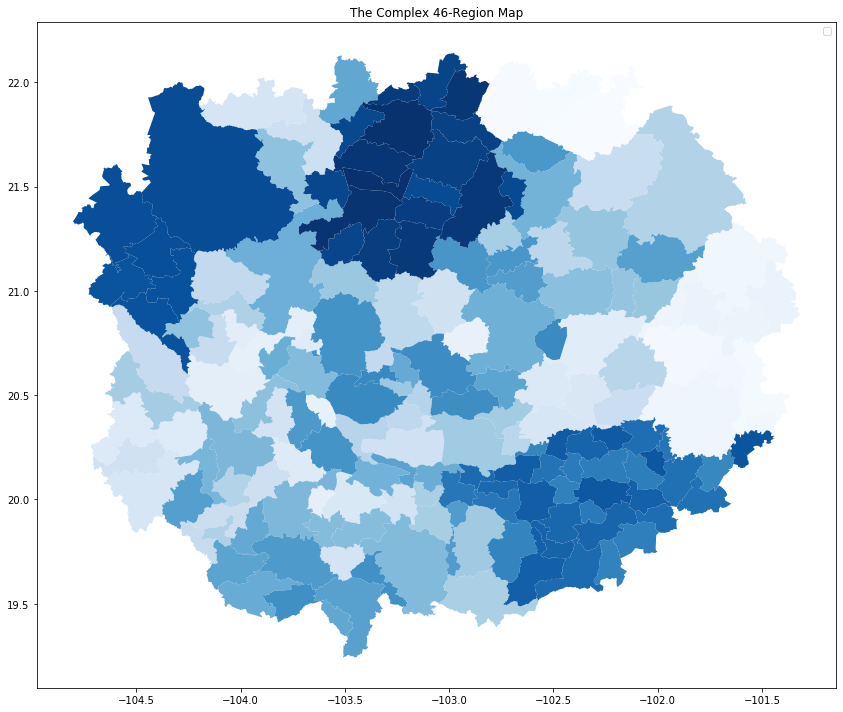

In [107]:
fig, ax = plt.subplots(figsize=(20,10))

# (urban_shapes).plot(ax=ax, color='black');

for i in range (1,2):
    
    loc_num = Reg_dict1[i]
    
    for each in range (len(loc_num)):
                
        (urban_shapes.loc[[loc_num[each]],:]).plot(ax=ax, color=give_hex(each/(len(loc_num)))
                                                   

plt.legend()

plt.title('The Complex 46-Region Map')

plt.tight_layout();

In [111]:
proximity = pd.read_csv('municipality_proximity_matrix_clave_actividad_economica_and_cve_mun_2014_A111A_H001A_6.csv')

In [112]:
proximity

Unnamed: 0      0      1      2        3        4        5        6  \
0            0   1001   1003   1005  11001.0  11008.0  11012.0  11016.0   
1            1   9002   9003   9004   9005.0   9006.0   9007.0   9008.0   
2            2   5001   5004   5005   5006.0   5007.0   5008.0   5010.0   
3            3   1002   1004   1006   1009.0   1010.0   1011.0  11013.0   
4            4   4001   4005   4008  31001.0  31002.0  31003.0  31004.0   
5            5  11001  11002  11003  11004.0  11005.0  11006.0  11007.0   
6            6   1001   1002   1003   1004.0   1005.0   1006.0   1007.0   
7            7   9002   9003   9004   9005.0   9006.0   9007.0   9008.0   
8            8   2003   2004   2005      NaN      NaN      NaN      NaN   
9            9  26001  26005  26009  26012.0  26013.0  26014.0  26016.0   
10          10   5009   5017   5024   5033.0   5035.0   5036.0  10004.0   
11          11   8001   8002   8003   8004.0   8006.0   8009.0   8010.0   
12          12   7002   7004   7005   7007.0   7008.0   7009.0   7012.0   
13          13  11001  11002  11003  11004.0  11005.0  11007.0  11008.0   
14          14   8001   8005   8028   8037.0   8050.0   8053.0      NaN   
15          15   2002   2003   2004   2005.0   2001.0  26048.0  26055.0   
16          16   4007   7005   7012   7013.0   7014.0   7016.0   7018.0   
17          17  20002  20021  20029  20041.0  20109.0  20142.0  20163.0   
18          18   8029   8046  10002  10019.0  10023.0  10026.0  10032.0   
19          19  19002  19003  19011  19013.0  19015.0  19016.0  19020.0   
20          20   8020   8030   8047   8065.0   8066.0  25001.0  25007.0   
21          21  10001  10003  10004  10005.0  10008.0  10014.0  10015.0   
22          22   7012   7017   7021   7025.0   7033.0   7043.0   7048.0   
23          23  14003  14006  14007  14011.0  14012.0  14017.0  14019.0   
24          24  23001  23002  23003  23005.0  23007.0  23008.0  23009.0   
25          25   4001   4002   4003   4004.0   4005.0   4006.0   4007.0   
26          26   8020   8030   8046   8047.0   8065.0   8066.0  25001.0   
27          27  12001  12002  12003  12004.0  12005.0  12006.0  12007.0   
28          28   3001   3003   3008      NaN      NaN      NaN      NaN   
29          29  20001  20006  20007  20013.0  20015.0  20017.0  20023.0   
30          30   6001   6002   6003   6004.0   6005.0   6006.0   6007.0   
31          31   9002   9003   9004   9005.0   9006.0   9007.0   9008.0   
32          32   7001   7003   7006   7008.0   7010.0   7011.0   7015.0   
33          33  24003  24012  24013  24014.0  24016.0  24026.0  24029.0   
34          34  19007  19014  19024  19030.0  19033.0  19036.0  24058.0   
35          35   5001   5004   5005   5006.0   5007.0   5008.0   5010.0   
36          36   5005   5012   5013   5015.0   5026.0   5037.0  19002.0   
37          37   1001   1002   1003   1004.0   1005.0   1006.0   1007.0   
38          38  26004  26006  26007  26011.0  26016.0  26019.0  26022.0   
39          39   4006   4010  23002  23004.0  23006.0  23010.0  31058.0   
40          40   7001   7002   7004   7005.0   7006.0   7007.0   7008.0   
41          41  12016  12038  12068  12073.0  16002.0  16006.0  16008.0   
42          42  20005  20008  20010  20014.0  20030.0  20036.0  20043.0   
43          43  11006  11034  11043  11045.0  13011.0  13014.0  13018.0   
44          44  13027  21002  21006  21014.0  21025.0  21028.0  21029.0   
45          45   5003   5012   5014   5019.0   5022.0   5025.0   5028.0   

          7        8  ...      642      643      644      645      646  \
0   11020.0  11023.0  ...      NaN      NaN      NaN      NaN      NaN   
1    9009.0   9010.0  ...      NaN      NaN      NaN      NaN      NaN   
2    5011.0   5016.0  ...      NaN      NaN      NaN      NaN      NaN   
3   11014.0  11022.0  ...      NaN      NaN      NaN      NaN      NaN   
4   31005.0  31006.0  ...      NaN      NaN      NaN      NaN      NaN   
5   11008.0  11009.0  ...      NaN

In [113]:
dict2 = pd.read_csv('municipality_proximity_matrix_clave_actividad_economica_and_cve_mun_2014_A111A_H001A_6.csv')

dict2

clave_entidad      1001      1002      1003      1004      1005  \
0              1001  1.000000  0.010345  0.048276  0.000000  0.100000   
1              1002  0.010345  1.000000  0.236559  0.416667  0.086022   
2              1003  0.048276  0.236559  1.000000  0.204301  0.215054   
3              1004  0.000000  0.416667  0.204301  1.000000  0.032258   
4              1005  0.100000  0.086022  0.215054  0.032258  1.000000   
...             ...       ...       ...       ...       ...       ...   
2451          32054  0.003448  0.500000  0.150538  0.411765  0.021505   
2452          32055  0.027586  0.350000  0.440860  0.216667  0.161290   
2453          32056  0.237931  0.053571  0.244048  0.047619  0.172619   
2454          32057  0.006897  0.388889  0.236559  0.470588  0.021505   
2455          32058  0.000000  0.277778  0.075269  0.205882  0.010753   

          1006      1007      1008      1009  ...     32049     32050  \
0     0.034483  0.044828  0.000000  0.000000  ...  0.034483  0.003448   
1     0.236842  0.275862  0.388889  0.305556  ...  0.225352  0.333333   
2     0.462366  0.548387  0.182796  0.129032  ...  0.397849  0.064516   
3     0.197368  0.195402  0.500000  0.294118  ...  0.211268  0.264706   
4     0.215054  0.193548  0.032258  0.032258  ...  0.193548  0.010753   
...        ...       ...       ...       ...  ...       ...       ...   
2451  0.144737  0.183908  0.464286  0.307692  ...  0.140845  0.461538   
2452  0.486842  0.471264  0.216667  0.133333  ...  0.464789  0.066667   
2453  0.154762  0.214286  0.029762  0.011905  ...  0.172619  0.017857   
2454  0.184211  0.218391  0.382353  0.264706  ...  0.267606  0.235294   
2455  0.039474  0.091954  0.250000  0.500000  ...  0.098592  0.352941   

         32051     32052     32053     32054     32055     32056     32057  \
0     0.010345  0.003448  0.000000  0.003448  0.027586  0.237931  0.006897   
1     0.555556  0.486486  0.444444  0.500000  0.350000  0.053571  0.388889   
2     0.236559  0.215054  0.215054  0.150538  0.440860  0.244048  0.236559   
3     0.472222  0.513514  0.500000  0.411765  0.216667  0.047619  0.470588   
4     0.032258  0.053763  0.021505  0.021505  0.161290  0.172619  0.021505   
...        ...       ...       ...       ...       ...       ...       ...   
2451  0.388889  0.405405  0.483871  1.000000  0.150000  0.023810  0.411765   
2452  0.283333  0.300000  0.266667  0.150000  1.000000  0.166667  0.266667   
2453  0.059524  0.059524  0.047619  0.023810  0.166667  1.000000  0.053571   
2454  0.416667  0.459459  0.411765  0.411765  0.266667  0.053571  1.000000   
2455  0.250000  0.243243  0.322581  0.423077  0.100000  0.000000  0.323529   

         32058  
0     0.000000  
1     0.277778  
2     0.075269  
3     0.205882  
4     0.010753  
...        ...  
2451  0.423077  
2452  0.100000  
2453  0.000000  
2454  0.323529  
2455  1.000000  

[2456 rows x 2457 columns]

In [115]:
new_list = pd.read_csv('region2.csv')
new_list

Unnamed: 0      0        1        2        3        4        5        6  \
0            0  14002  14031.0  14034.0  14039.0  14040.0  14056.0  14060.0   
1            1   9014   9016.0  12031.0  12047.0  15004.0  15008.0  15032.0   
2            2   5001   5008.0   5016.0   5026.0   5030.0  19001.0  19003.0   
3            3  24002  24004.0  24009.0  24015.0  24017.0  24028.0  24030.0   
4            4   4005   4008.0  31001.0  31002.0  31004.0  31005.0  31006.0   
5            5  11001  11006.0  11016.0  13040.0  13047.0  15071.0  15106.0   
6            6   1001  11013.0  11020.0  11024.0  11036.0  13084.0  14005.0   
7            7   9002   9005.0   9006.0   9007.0   9015.0  15033.0  15080.0   
8            8   2004      NaN      NaN      NaN      NaN      NaN      NaN   
9            9  26001  26005.0  26009.0  26013.0  26014.0  26020.0  26021.0   
10          10   5009   5017.0   5035.0   5036.0  10006.0  10007.0  10012.0   
11          11   8002   8003.0   8004.0   8006.0   8009.0   8010.0   8011.0   
12          12   7058   7121.0   7122.0   7123.0   7124.0   7033.0   7045.0   
13          13  11002  11003.0  11004.0  11005.0  11007.0  11009.0  11010.0   
14          14   8001   8005.0   8028.0   8037.0   8050.0   8053.0      NaN   
15          15   2002   2003.0   2005.0   2001.0  26048.0  26055.0      NaN   
16          16   7016   7050.0  27003.0  27004.0  27009.0      NaN      NaN   
17          17  20002  20021.0  20029.0  20041.0  20109.0  20163.0  20169.0   
18          18   8029   8046.0  10002.0  10019.0  10026.0  10034.0  10035.0   
19          19  19013  19015.0  19020.0  19022.0  19040.0  28005.0  28007.0   
20          20   8020   8030.0   8047.0   8065.0   8066.0  25007.0  25010.0   
21          21  10001  10003.0  10004.0  10005.0  10008.0  10015.0  10018.0   
22          22   7074  20005.0  20057.0  20190.0  20198.0  20207.0  20265.0   
23          23  14003  14006.0  14007.0  14019.0  14020.0  14036.0  14038.0   
24          24  23011  23001.0  23003.0  23005.0  23007.0  23008.0  23009.0   
25          25   4001   4002.0   4003.0   4004.0   4007.0   4009.0   4011.0   
26          26  25001  25002.0  25003.0  25011.0  25013.0  25015.0  25018.0   
27          27  12001  12002.0  12003.0  12004.0  12005.0  12006.0  12007.0   
28          28   3001   3003.0   3008.0      NaN      NaN      NaN      NaN   
29          29  20001  20006.0  20007.0  20013.0  20015.0  20017.0  20023.0   
30          30   6001   6002.0   6003.0   6004.0   6005.0   6006.0   6007.0   
31          31   9003   9004.0   9008.0   9009.0   9010.0   9011.0   9012.0   
32          32   7120   7003.0   7010.0   7015.0   7035.0   7036.0   7037.0   
33          33  24026  28008.0  28038.0  30154.0      NaN      NaN      NaN   
34          34  19007  19014.0  19024.0  19033.0  19036.0  28001.0  28006.0   
35          35   5004   5006.0   5007.0   5010.0   5011.0   5015.0   5018.0   
36          36   5005   5012.0   5013.0  19002.0  19005.0  19032.0  19044.0   
37          37   1002   1003.0   1004.0   1005.0   1006.0   1007.0   1008.0   
38          38  26004  26006.0  26007.0  26011.0  26016.0  26019.0  26027.0   
39          39   4006   4010.0  23002.0  23004.0  23006.0  23010.0  31058.0   
40          40   7001   7002.0   7004.0   7005.0   7006.0   7007.0   7008.0   
41          41  12016  12038.0  12068.0  12073.0  16002.0  16006.0  16008.0   
42          42  20008  20010.0  20014.0  20030.0  20036.0  20043.0  20052.0   
43          43  11034  11043.0  11045.0  13011.0  13014.0  13018.0  13025.0   
44          44  21002  21006.0  21025.0  21043.0  21064.0  21068.0  21072.0   
45          45   5003   5014.0   5019.0   5022.0   5025.0   5028.0   5032.0   

          7        8  ...      365      366      367      368      369  \
0   14069.0  14071.0  ...      NaN      NaN      NaN      NaN      NaN   
1   15041.0  15066.0  ...      NaN      NaN      NaN      NaN      NaN   
2   19016.0  19023.0  ...      NaN      NaN      NaN      NaN      N